In [67]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import binarize

import numpy as np
import scipy as sp
import scipy.io as sio

import h5py

import seaborn as sns
import matplotlib.pyplot as plt

import pickle 

In [32]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Definining DeepSea model

In [2]:
def DeepSEA():
    nkernels = [320,480,960]
    in_size = (1,1000,4)
    l2_lam = 5e-07 
    l1_lam = 1e-08 

    model = Sequential()
    model.add(Conv2D(nkernels[0], kernel_size=(1,8), strides=(1,1), padding='same', input_shape=in_size, kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))
    
    #expecting 
    #(4,250,320) here

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('relu'))
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('sigmoid'))
    
    return model

# Loading Data

In [3]:
valid = sio.loadmat("../deepsea_train/valid.mat")
train = h5py.File("../deepsea_train/train.mat")
test = sio.loadmat("../deepsea_train/test.mat")

In [4]:
valid_X = valid["validxdata"]
valid_X = np.expand_dims(valid_X, 3)
valid_X = np.transpose(valid_X, axes=(0,3,2,1))
valid_Y = valid["validdata"]

In [5]:
train_X = train["trainxdata"][()]
train_X = np.expand_dims(train_X, 3)
train_X = np.transpose(train_X, axes=(2,1,0,3))
train_X = np.transpose(train_X, axes=(0,3,2,1))
train_Y = np.transpose(train["traindata"][()])

In [6]:
test_X = test["testxdata"]
test_X = np.expand_dims(test_X, 3)
test_X = np.transpose(test_X, axes=(0,3,2,1))
test_Y = test["testdata"]

# Training DeepSea

In [24]:
model = DeepSEA()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}-full.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
result = model.fit(train_X, train_Y,
          epochs=10, batch_size=256,
          callbacks=callbacks_list,
          initial_epoch=5, 
          validation_data=(valid_X, valid_Y))

Train on 4400000 samples, validate on 8000 samples
Epoch 6/10
  16896/4400000 [..............................] - ETA: 14047s - loss: 0.0675 - acc: 0.9800

In [79]:
save_obj(result.history, "history_run01_epoch00-04.pkl")

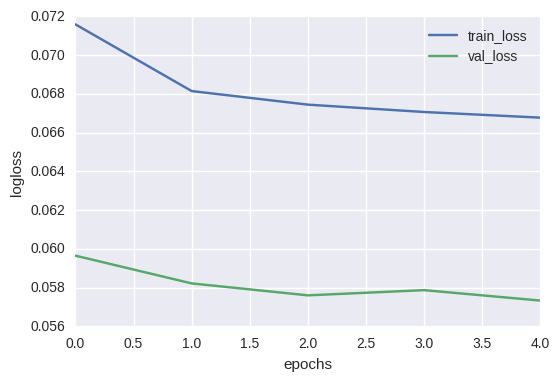

In [49]:
fig = plt.figure()
plt.plot(range(len(result.history["loss"])), result.history["loss"], label="train_loss")
plt.plot(range(len(result.history["val_loss"])), result.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("logloss")
plt.legend()

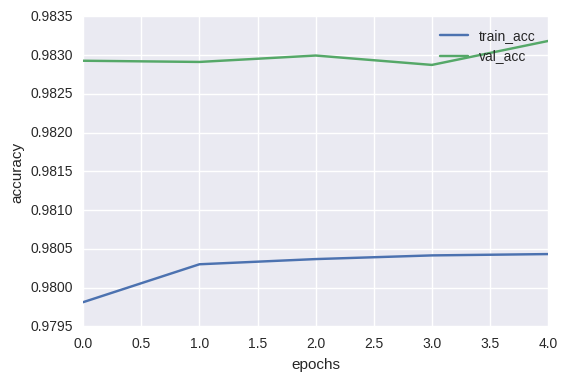

In [50]:
fig = plt.figure()
plt.plot(range(len(result.history["acc"])), result.history["acc"], label="train_acc")
plt.plot(range(len(result.history["val_acc"])), result.history["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

# Visualizing result (after 5 epochs)

In [51]:
prediction = model.predict(test_X)

In [75]:
start = 500
end = 1000
num_start = 100
num_end = 300

([], <a list of 0 Text xticklabel objects>)

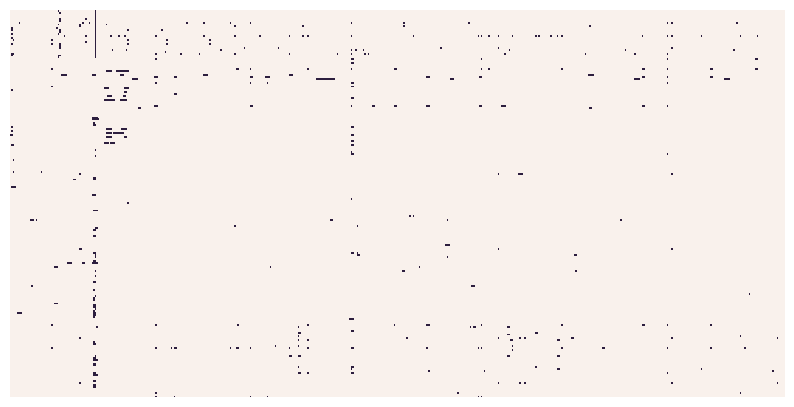

In [76]:
plt.figure(figsize=(10,5))
sns.heatmap(np.transpose(test_Y[start:end, num_start:num_end]), cbar=False)
plt.yticks([],[])
plt.xticks([],[])

([], <a list of 0 Text xticklabel objects>)

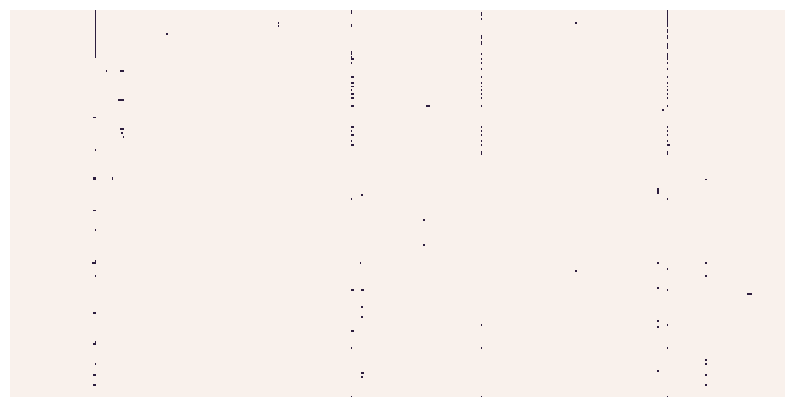

In [77]:
plt.figure(figsize=(10,5))
sns.heatmap(np.transpose(binarize(prediction[start:end, num_start:num_end], threshold=0.5)), cbar=False)
plt.yticks([],[])
plt.xticks([],[])

([], <a list of 0 Text xticklabel objects>)

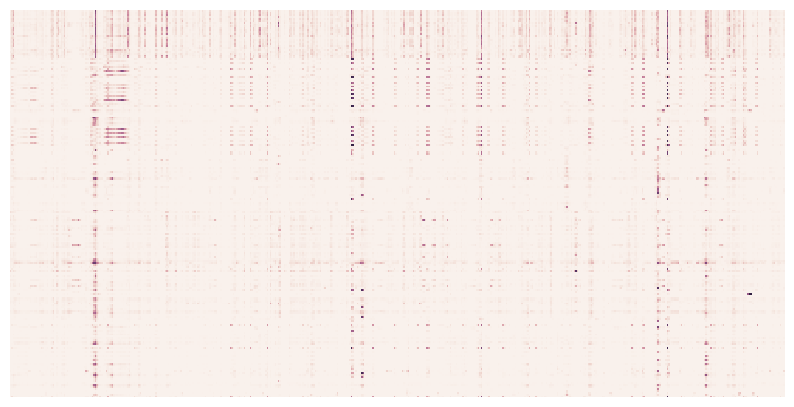

In [78]:
plt.figure(figsize=(10,5))
sns.heatmap(np.transpose(prediction[start:end, num_start:num_end]), cbar=False)
plt.yticks([],[])
plt.xticks([],[])

# Looking at the result